<a href="https://colab.research.google.com/github/fatimaabuhamdeh/AI/blob/main/ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [159]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix, accuracy_score

In [129]:
data = pd.read_csv('/content/Train.csv')

In [133]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33908 entries, 0 to 33907
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   feature_0   33908 non-null  float64
 1   feature_1   33908 non-null  float64
 2   feature_2   33908 non-null  float64
 3   feature_3   33908 non-null  float64
 4   feature_4   33908 non-null  float64
 5   feature_5   33908 non-null  float64
 6   feature_6   33908 non-null  float64
 7   feature_7   33908 non-null  int64  
 8   feature_8   33908 non-null  int64  
 9   feature_9   33908 non-null  int64  
 10  feature_10  33908 non-null  int64  
 11  feature_11  33908 non-null  int64  
 12  feature_12  33908 non-null  int64  
 13  feature_13  33908 non-null  int64  
 14  feature_14  33908 non-null  int64  
 15  feature_15  33908 non-null  int64  
 16  labels      33908 non-null  int64  
dtypes: float64(7), int64(10)
memory usage: 4.4 MB


In [134]:
data.isnull().sum()

feature_0     0
feature_1     0
feature_2     0
feature_3     0
feature_4     0
feature_5     0
feature_6     0
feature_7     0
feature_8     0
feature_9     0
feature_10    0
feature_11    0
feature_12    0
feature_13    0
feature_14    0
feature_15    0
labels        0
dtype: int64

In [135]:
data = data[['feature_0','feature_1','feature_2','feature_3']]

In [136]:
data['feature_1-feature_2'] = data['feature_1']-data['feature_2']
data['feature_0-feature_3'] = data['feature_3']-data['feature_0']
data['3day Ma'] = data['feature_3'].shift(1).rolling(window=3).mean()
data['10day Ma'] = data['feature_3'].shift(1).rolling(window=10).mean()
data['30day Ma'] = data['feature_3'].shift(1).rolling(window=30).mean()
data['std_dev'] = data['feature_3'].rolling(5).std()

In [137]:
data['price_Rise'] = np.where(data['feature_3'].shift(-1)>data['feature_3'],1,0)

In [138]:
data = data.dropna()

In [139]:
data = data.iloc[:,4:]

In [140]:
n = data.shape[0]
p = data.shape[1]
data = data.values

In [141]:
train_start = 0
train_end = int(np.floor(0.8*n))
test_start = train_end + 1
test_end = n
data_train = data[np.arange(train_start,train_end),:]
data_test = data[np.arange(test_start,test_end),:]

In [142]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(data_train)
data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)

In [143]:
X_train = data_train[:,0:-1]
y_train = data_train[:,-1]
X_test = data_test[:,0:-1]
y_test = data_test[:,-1]

In [144]:
import tensorflow.compat.v1 as tfv1
n_features = X_train.shape[1]
n_neurons_1 = 512
n_neurons_2 = 256
n_neurons_3 = 128
net = tfv1.InteractiveSession()

/usr/local/lib/python3.10/dist-packages/tensorflow/python/client/session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [145]:
X = tf.keras.Input(shape=(n_features,), dtype=tf.float32)
Y = tf.keras.Input(shape=(1,), dtype=tf.float32)

In [146]:
sigma = 1
weight_initializer = tfv1.variance_scaling_initializer(mode="fan_avg",distribution="uniform",scale=sigma)
bias_initializer = tf.zeros_initializer()

In [147]:
w_hidden_1 = tf.Variable(weight_initializer([n_features,n_neurons_1]))
bias_hidden_1 = tf.Variable(bias_initializer([n_neurons_1]))

w_hidden_2 = tf.Variable(weight_initializer([n_neurons_1,n_neurons_2]))
bias_hidden_2 = tf.Variable(bias_initializer([n_neurons_2]))

w_hidden_3 = tf.Variable(weight_initializer([n_neurons_2,n_neurons_3]))
bias_hidden_3 = tf.Variable(bias_initializer([n_neurons_3]))

w_out = tf.Variable(bias_initializer([n_neurons_3,1]))
bias_out = tf.Variable(bias_initializer([1]))

In [148]:
hidden_1 = tf.nn.relu(tf.add(tf.matmul(X,w_hidden_1),bias_hidden_1))
hidden_2 = tf.nn.relu(tf.add(tf.matmul(hidden_1,w_hidden_2),bias_hidden_2))
hidden_3 = tf.nn.relu(tf.add(tf.matmul(hidden_2,w_hidden_3),bias_hidden_3))

out = tf.transpose(tf.add(tf.matmul(hidden_3,w_out),bias_out))

In [149]:
#mse = tf.reduce_mean(tf.square(out - Y))

In [150]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Dense(units=64, activation='relu', input_shape=(n_features,)),
    Dense(units=1)
])
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mean_squared_error')

In [151]:
batch_size = 100
epochs = 10
for e in range(epochs):
    shuffle_data = np.random.permutation(np.arange(len(y_train)))
    X_train = X_train[shuffle_data]
    y_train = y_train[shuffle_data]

    for i in range(0, len(y_train)//batch_size):
        start = i*batch_size
        end = (i+1)*batch_size
        batch_x = X_train[start:end]
        batch_y = y_train[start:end]

        model.fit(batch_x, batch_y, epochs=1, batch_size=batch_size)

1/1 [==============================] - 0s 7ms/step - loss: 0.9785


In [152]:
pred = model.predict(X_test)
y_pred = pred > 0.5

212/212 [==============================] - 0s 1ms/step


In [153]:
df = pd.DataFrame(data)
df.isnull().sum()

0    0
1    0
2    0
3    0
4    0
5    0
6    0
dtype: int64

In [155]:
df['Tomorrows Returns'] = 0
df['feature_3'] = np.random.randn(len(df))
df['Tomorrows Returns'] = np.log(df['feature_3']/df['feature_3'].shift(1))
df['Tomorrows Returns'] = df['Tomorrows Returns'].shift(-1)

In [156]:
df['y_pred'] = np.random.choice([True, False], size=df.shape[0])
df['Strategy Returns'] = np.where(df['y_pred'] == True, df['Tomorrows Returns'], - df['Tomorrows Returns'])

In [157]:
df['Cumulative Market Returns'] = np.cumsum(df['Tomorrows Returns'])
df['Cumulative Strategy Returns'] = np.cumsum(df['Strategy Returns'])

In [160]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix", confusion_matrix)
print("Accuracy Score", accuracy_score(y_test, y_pred))

Confusion Matrix [[   0 3373   19]
 [   0    0    0]
 [   0 3369   14]]
Accuracy Score 0.002066420664206642


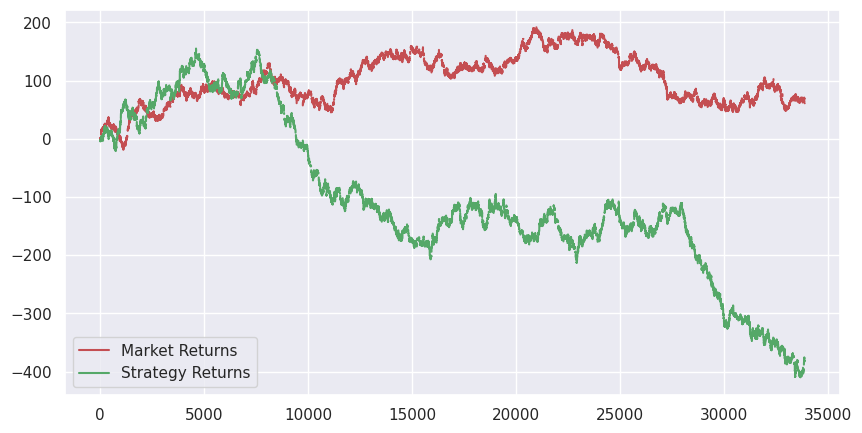

In [162]:
plt.figure(figsize=(10,5))
plt.plot(df['Cumulative Market Returns'], color='r', label= 'Market Returns')
plt.plot(df['Cumulative Strategy Returns'], color='g', label= 'Strategy Returns')
plt.legend()
plt.show()